# Import relevant libraries/modules etc

In [1]:
import numpy as np
import xarray as xr
import rasterio
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import datetime
import pandas as pd
from rasterio import features
from rasterio_to_xarray import rasterio_to_xarray, xarray_to_rasterio, xarray_to_rasterio_by_band
import rasterstats
import fiona
from tqdm import tqdm
from dateutil.parser import parse
from shapely.geometry import shape
from rasterstats.io import read_features

In [ ]:
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler, ProgressBar
pbar = ProgressBar()
pbar.register()

# Read NetCDF files in to create dataset with all data in

In [2]:
PM25 = xr.open_mfdataset(r'C:\MAIACData\nc_monthly_daily\*PM25.nc')['data']

In [ ]:
PM25

# Extract data over one pixel
- Find the x and y location of the pixels within the image
- Extract the PM2.5 data over the whole time period for the pixels corresponding to each site
- Save the PM2.5 estimates out as a csv for each site
- Merge the PM2.5 timeseries data for the three sites based on the dimension 'time'
- Create summary statistics for each site
- Create a graph showing the variation in PM2.5 for all sites over time

In [4]:
# Code to use the affine information associated with the images to find the x and y location 
# of the pixels within the images using the Easting and Northing coordinates
# University of Southampton: 442389, 115316
# Bolderwood: 424469, 108204
#West Lulworth: 382611, 80604

a = PM25.attrs['affine']
a = rasterio.Affine.from_gdal(*a)
~a * (382611, 80604)

(1142.2454942987702, 1012.5596715430838)

In [ ]:
PM25 = PM25.isel(time=np.argsort(PM25.time))

In [ ]:
ts = PM25.isel(x=1058, y=1073).load()

In [ ]:
ts

In [ ]:
result = ts.to_dataframe()

In [ ]:
result.dropna()

In [ ]:
result.to_csv(r'D:\Annies_Dissertation\Analysis\Timeseries\Westlulworth.csv')

## Merging timeseries data for the three sites

In [ ]:
Unisoton = pd.read_csv(r'D:\Annies_Dissertation\Analysis\Timeseries\UniSoton.csv', parse_dates=['time'])

In [ ]:
Unisoton[:10]

In [ ]:
Unisoton = Unisoton.set_index('time').rename(columns={'data':'Uni_of_Soton'})

In [ ]:
Bolderwood = pd.read_csv(r'D:\Annies_Dissertation\Analysis\Timeseries\Bolderwood.csv', parse_dates=['time'])

In [ ]:
Bolderwood[:10]

In [ ]:
Bolderwood = Bolderwood.set_index('time').rename(columns={'data':'Bolderwood'})

In [ ]:
result = pd.merge(Unisoton, Bolderwood, left_index=True, right_index=True)

In [ ]:
result[:10]

In [ ]:
Westlulworth = pd.read_csv(r'D:\Annies_Dissertation\Analysis\Timeseries\Westlulworth.csv', parse_dates=['time'])

In [ ]:
Westlulworth[:10]

In [ ]:
Westlulworth = Westlulworth.set_index('time').rename(columns={'data':'West_Lulworth'})

In [ ]:
result_3 = pd.merge(result, Westlulworth, left_index=True, right_index=True)

In [ ]:
result_3 = result_3[['Uni_of_Soton', 'Bolderwood', 'West_Lulworth']]

In [ ]:
result_3.dropna().to_csv(r'D:\Annies_Dissertation\Analysis\Timeseries\Timeseries.csv')

In [ ]:
result_3[:10]

## Create summary statistics for each site

In [ ]:
result_3.Uni_of_Soton.describe()

In [ ]:
result_3.Bolderwood.describe()

In [ ]:
result_3.West_Lulworth.describe()

## Create a graph to show the variation in PM2.5 for the three sites over time

In [ ]:
result_3.plot(figsize=(20,8))
plt.ylabel('PM2.5')
plt.xlabel('Date')
plt.savefig(r'D:\Annies_Dissertation\Analysis\Timeseries\Timeseries_2000_2014.jpeg')

In [ ]:
result_3_sub = pd.read_csv(r'D:\Annies_Dissertation\Analysis\Timeseries\Timeseries_subset.csv')

In [ ]:
result_3_sub[:5]

In [ ]:
result_3_sub = result_3_sub.set_index('time')

In [ ]:
result_3_sub.plot(figsize=(20,8))
plt.ylabel('PM2.5')
plt.xlabel('Date')
plt.savefig(r'D:\Annies_Dissertation\Analysis\Timeseries\Timeseries_2009_2014.jpeg')

# Analysis
## overall PM2.5 average of every pixel

In [ ]:
om = PM25.mean(dim='time', keep_attrs=True)

In [ ]:
xarray_to_rasterio(overall_mean, r'D:\Annies_Dissertation\Analysis\overall_mean.tif')

## PM2.5 Averages
### Monthly

In [ ]:
monthly_mean = PM25.groupby('time.month').mean(dim='time', keep_attrs=True)

In [ ]:
monthly_mean.coords

In [ ]:
monthly_mean.attrs

In [ ]:
figure(figsize=(20, 12))
monthly_mean.plot(col='month', robust=True)

In [ ]:
xarray_to_rasterio_by_band(monthly_mean, r'D:\Annies_Dissertation\Analysis\monthly\monthly_mean_', dim='month')

### Seasonal

In [ ]:
seasonal_mean = PM25.groupby('time.season').mean(dim='time', keep_attrs=True)

In [ ]:
seasonal_mean.coords

In [ ]:
figure(figsize=(20, 12))
seasonal_mean.plot(col='season', robust=True)

In [ ]:
xarray_to_rasterio_by_band(seasonal_mean, r'D:\Annies_Dissertation\Analysis\seasonal\seasonal_mean_', dim='season')

### Yearly

In [ ]:
yearly_mean = PM25.groupby('time.year').mean(dim='time', keep_attrs=True)

In [ ]:
yearly_mean.coords

In [ ]:
figure(figsize=(20, 12))
yearly_mean.plot(col='year', robust=True)

In [ ]:
xarray_to_rasterio_by_band(yearly_mean, r'D:\Annies_Dissertation\Analysis\yearly\yearly_mean_', dim='year')

## Standard deviation of AP for each pixel over time

In [ ]:
std = PM25.groupby('time.year').std(dim = 'time', keep_attrs=True)

In [ ]:
std = PM25.std(dim = 'time', keep_attrs=True)

In [ ]:
std.coords

In [ ]:
figure(figsize=(20, 12))
std.plot(col='year', robust=True)

In [ ]:
xarray_to_rasterio(std, r'D:\Annies_Dissertation\Analysis\overall_std.tif')

# Count of values that aren't missing

In [ ]:
observations = PM25.count(dim='time', keep_attrs=True)

In [ ]:
xarray_to_rasterio(observations, r'D:\Annies_Dissertation\Analysis\observations_count.tif')

## Read in subset count image- just Wessex

In [6]:
subset_count = rasterio_to_xarray(r'D:\Annies_Dissertation\Analysis\Clipped\obs_arc1.tif')

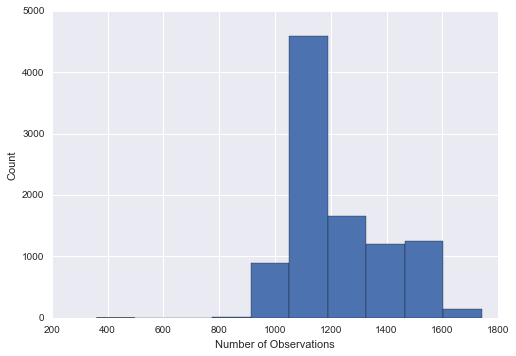

In [10]:
count_histo = subset_count.plot.hist()
plt.xlabel('Number of Observations')
plt.savefig(r'D:\Annies_Dissertation\Analysis\count_histogram_subset.jpeg')

## Buncefield fire

In [ ]:
PM25 = PM25.isel(time=np.argsort(PM25.time))

In [ ]:
B_fire = PM25.sel(time='2005-12-15')

In [ ]:
B_fire

In [ ]:
%time xarray_to_rasterio(B_fire, r'D:\Annies_Dissertation\Analysis\Specific_events\Buncefield\B_fire\15122005.tif')

## Doesn't work

In [ ]:
B_fire = PM25.sel(time=slice('2005-12-10', '2005-12-12'))

In [ ]:
xarray_to_rasterio_by_band(B_fire, r'D:\Annies_Dissertation\Analysis\Specific_events\Buncefield\B_fire\B_fire_', dim='time')

## Number of observations each year greater than legislation

In [14]:
PM25 = PM25.isel(time=np.argsort(PM25.time))

In [15]:
After2010 = PM25.sel(time=slice('2010', '2016'))

In [ ]:
Count_10 = After2010.groupby('time.year').count(After2010>10)

In [ ]:
figure(figsize=(20, 12))
Count_10.plot(col='year', robust=True)